# Benchmarking Our Algorithm against others

In [1]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from panav.sequential import sequential_planning
from panav.PIBT import PIBT_plan
from panav.SAMP.solvers import Tube_Planning



from time import time
import pickle as pkl

%load_ext autoreload
%autoreload 2

In [3]:

bloating_r = 0.5
vmax = 1.0

n_agents = list(range(2,21,2))
# n_agents = [6]

TIMEOUT = 60 # 1 minute timeout

# Algorithms
algs = {  "PIBT": lambda hg: PIBT_plan(hg,vmax,bloating_r,TIMEOUT),
        "S2M2": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Simple_MILP_Planning",TIMEOUT=TIMEOUT)[0],
        "PBS_Tube": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Tube_Planning",TIMEOUT=TIMEOUT)[0],
        "TAHP": lambda hg: TAHP(hg,vmax=vmax,bloating_r=bloating_r,TIMEOUT=TIMEOUT),
        "Seq_Tube": lambda hg: sequential_planning(Tube_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT),      
        # "Seq_Temp_Obs": lambda hg: sequential_planning(Simple_MILP_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT)
        }

timeouted = {alg:False for alg in algs}

results = []

env_name = "MultiTunnel"


In [4]:
# Load checkpoint if necessary

with open("./data/{}_misc.pkl".format(env_name),'rb') as fp:
    ck = pkl.load(fp)
    cur_N = ck['cur_N']



with open("./data/{}.pkl".format(env_name),'rb') as fp:
    results = pkl.load(fp)

In [5]:
cur_N = 20
# Experiments
for i in range(len(n_agents)):
    
    N = n_agents[i]
    if N<cur_N:
        continue

    env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5, N_agent = N)
    HG = HybridGraph(env,bloating_r)

    # Save checkpoint data
    with open("./data/{}_misc.pkl".format(env_name),'wb') as fp:
        pkl.dump({"TIMEOUT":TIMEOUT,"HG":HG,'cur_N':N},fp)
    to_remove = []
    for e in HG.edges:
        if HG.edges[e]['type']=='soft':
            # HG.edges[e]['weight'] = 0
            # pass
            u,v = e
            if HG.nodes[u]['type']== HG.nodes[v]['type']=='tunnel' and \
                                    HG.nodes[u]['open_space_id'] == HG.nodes[v]['open_space_id']:
                to_remove.append(e) # Remove the soft edges connecting two tunnel endpoints for this particular environment
    for e in to_remove:
        HG.remove_edge(*e)

    for name,alg in algs.items():

        if timeouted[name]:
            continue
        
        print("Alg:", name, "N agent:",N)

        result = {}
        
        t0 = time()
        plan = alg(HG)
        t = time()-t0
        
        result['plan'] = plan
        result['time'] = t

        result['N_agent'] = N
        result['alg_name'] = name

        result["TIMEOUT"]=TIMEOUT
        result["HG"]=HG

        results.append(result)

        
        if t>TIMEOUT:
            timeouted[name] = True
            print("Time out for algorithm", name, "N agent = ", N)


        
        

    # Save checkpoint data
    with open("./data/{}.pkl".format(env_name),'wb') as fp:
        pkl.dump(results,fp)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-21
Alg: PIBT N agent: 20


/home/naliseas-workstation/miniconda2/envs/MAMP/lib/python3.10/site-packages/cvxpy/problems/problem.py:1413: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Alg: S2M2 N agent: 20
PBS Time Elapsed: 0.9227023124694824
PBS Time Elapsed: 0.9980983734130859
PBS Time Elapsed: 1.1154000759124756
PBS Time Elapsed: 1.225731372833252
PBS Time Elapsed: 1.372143268585205
PBS Time Elapsed: 1.5735092163085938
PBS Time Elapsed: 4.033384561538696
PBS Time Elapsed: 4.174771070480347
PBS Time Elapsed: 4.463892698287964
PBS Time Elapsed: 5.071764707565308
PBS Time Elapsed: 5.318774461746216
PBS Time Elapsed: 6.1110358238220215
PBS Time Elapsed: 6.549756765365601
PBS Time Elapsed: 6.93738579750061
PBS Time Elapsed: 8.063769578933716
PBS Time Elapsed: 9.825706243515015
PBS Time Elapsed: 10.179387092590332
PBS Time Elapsed: 10.523092269897461
PBS Time Elapsed: 11.222871541976929
PBS Time Elapsed: 12.533626317977905
PBS Time Elapsed: 15.04698657989502
PBS Time Elapsed: 17.43772029876709
PBS Time Elapsed: 27.40933918952942
PBS Time Elapsed: 27.726781368255615
PBS Time Elapsed: 28.14162397

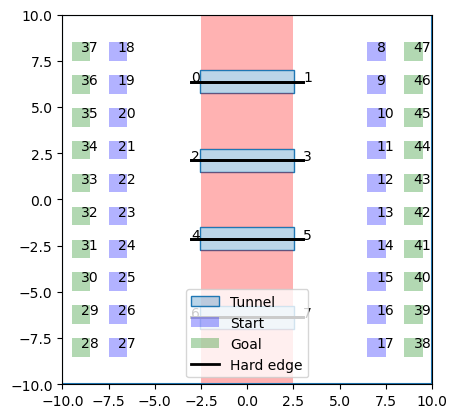

In [16]:
from panav.viz import draw_hybrid

draw_hybrid(HG)